**Requirements:**
- `plots/[model_name]/architecture.py` should contain the model class (this is to encode individual run's architectures.
- Model checkpoints should be in: `model_checkpoint/[model_name]/` (done automatically)
- Loss files should be in: `plots/[model_name]/[model_name]_loss.npz` (done automatically)

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
from shearnet.core.dataset import generate_dataset, split_combined_images
from shearnet.core.train import train_model
from shearnet import EnhancedGalaxyNN
import jax.random as random
import jax.numpy as jnp
import numpy as np
import optax
import os
from dataclasses import dataclass
from typing import List, Optional
import sys
import importlib.util

from flax.training import checkpoints, train_state
from shearnet.utils.metrics import eval_model, eval_ngmix, eval_mcal
from shearnet.utils.plot_helpers import (
    plot_residuals, 
    visualize_samples, 
    plot_true_vs_predicted, 
    animate_model_epochs
)
from shearnet.utils.notebook_output_system import (
    log_print, save_plot, log_array_stats, experiment_section, get_output_manager
)

@dataclass
class ModelConfig:
    """Configuration for a ShearNet model to compare"""
    name: str  # Display name for plots
    model_dir_prefix: str  # Directory prefix to search for (e.g., 'cnn1', 'cnn2')
    color: str  # Color for plots
    marker: str = 'o'  # Marker style for scatter plots
    galaxy_model_type: str = 'cnn'  # Galaxy model type
    psf_model_type: str = 'cnn'  # PSF model type

def load_model_and_evaluate(model_config, rng_key, test_galaxy_images, test_psf_images, test_labels, base_checkpoint_path, base_data_path):
    """Load a model and evaluate it using its saved architecture"""
    
    # Path to the saved architecture file
    arch_file = os.path.join(base_data_path, "plots", model_config.model_dir_prefix, "architecture.py")
    
    if not os.path.exists(arch_file):
        raise FileNotFoundError(f"Architecture file not found: {arch_file}")
    
    print(f"Loading architecture from: {arch_file}")
    
    # Dynamically import the architecture module
    spec = importlib.util.spec_from_file_location(f"{model_config.model_dir_prefix}_arch", arch_file)
    arch_module = importlib.util.module_from_spec(spec)
    sys.modules[f"{model_config.model_dir_prefix}_arch"] = arch_module
    spec.loader.exec_module(arch_module)
    
    # Look for ForkLike model class
    if hasattr(arch_module, 'ForkLike'):
        model_class = getattr(arch_module, 'ForkLike')
        print(f"Found model class: ForkLike")
        # Create model instance with specified model types
        model = model_class(galaxy_model_type=model_config.galaxy_model_type, psf_model_type=model_config.psf_model_type)
    else:
        # Fallback: create ForkLike with specified types
        print(f"No ForkLike class found in {arch_file}, using default ForkLike")
        from shearnet.core.models import ForkLike
        model = ForkLike(galaxy_model_type=model_config.galaxy_model_type, psf_model_type=model_config.psf_model_type)
        
    init_params = model.init(rng_key, jnp.ones_like(test_galaxy_images[0]), jnp.ones_like(test_psf_images[0]))
    state = train_state.TrainState.create(
        apply_fn=model.apply, params=init_params, tx=optax.adam(1e-3)
    )
    
    # Find matching checkpoint directory
    matching_dirs = [
        d for d in os.listdir(base_checkpoint_path) 
        if os.path.isdir(os.path.join(base_checkpoint_path, d)) and d.startswith(model_config.model_dir_prefix)
    ]
    
    print(f"Found {len(matching_dirs)} matching directories for {model_config.name}: {matching_dirs}")
    
    if not matching_dirs:
        raise FileNotFoundError(f"No directory found for {model_config.name} with prefix: {model_config.model_dir_prefix}")
    
    # Use the latest directory if multiple found
    model_dir = os.path.join(base_checkpoint_path, sorted(matching_dirs)[-1])
    print(f"Loading {model_config.name} from: {model_dir}")
    
    # Restore checkpoint
    state = checkpoints.restore_checkpoint(ckpt_dir=model_dir, target=state)
    
    # Evaluate
    results = eval_model(state, test_galaxy_images, test_psf_images, test_labels)
    return results

In [2]:
# ========================================================================================
# CONFIGURATION: MODIFY THIS TO SET UP YOUR COMPARISON
# ========================================================================================

# Define the models you want to compare
model_configs = [
    ModelConfig(
        name="ShearNet",
        model_dir_prefix="research_backed_galaxy_resnet_low_noise",
        color="blue", 
        marker="s",
        galaxy_model_type="research_backed",
        psf_model_type="cnn"
    ),
    ModelConfig(
        name="Pseudo ShearNet",
        model_dir_prefix="research+original_new_lr_and_optimizer",
        color="yellow",
        marker="^",
        galaxy_model_type="research_backed",
        psf_model_type="cnn"
    ),
]

# Set whether to include NGMix comparison
include_ngmix = False  # Set to False if you don't want NGMix comparison

# Print configuration
log_print("="*50)
log_print("BENCHMARK CONFIGURATION")
log_print("="*50)
log_print(f"Models to compare: {[config.name for config in model_configs]}")
log_print(f"Include NGMix: {include_ngmix}")
log_print("="*50)

DEBUG: Current working directory: /home/adfield/ShearNet/notebooks
DEBUG: Found 'notebooks' in current path
DEBUG: Attempting to create directory: /home/adfield/ShearNet/notebooks/out
DEBUG: Directory created/exists: /home/adfield/ShearNet/notebooks/out
DEBUG: Directory is writable: True
DEBUG: Created new output file: /home/adfield/ShearNet/notebooks/out/out.md
ShearNet Output Manager initialized:
  Output directory: /home/adfield/ShearNet/notebooks/out
  Output file: /home/adfield/ShearNet/notebooks/out/out.md
  Directory exists: True
  Can write to directory: True
BENCHMARK CONFIGURATION
Models to compare: ['Forklens', 'Pseudo Forklens']
Include NGMix: False


In [3]:
with experiment_section("Test Dataset Generation"):
    rng_key = random.PRNGKey(42)
    combined_test_images, test_labels, test_obs = generate_dataset(5000, 0.25, npix=53, scale=0.141, type='gauss', exp='ideal', nse_sd=1e-5, seed=42, return_obs=True)
    # CONTROL NOISE WITH ", nse_sd=_____" THIS DEFAULTS TO 1e-5

    # Split into separate galaxy and PSF arrays
    test_galaxy_images, test_psf_images = split_combined_images(combined_test_images)
    
    log_print(f"Generated {len(test_galaxy_images)} test samples")
    log_print(f"Galaxy image shape: {test_galaxy_images.shape}")
    log_print(f"PSF image shape: {test_psf_images.shape}")
    log_print(f"Labels shape: {test_labels.shape}")
    
    # Log some array statistics
    log_array_stats("test_galaxy_images", test_galaxy_images)
    log_array_stats("test_psf_images", test_psf_images)
    log_array_stats("test_labels", test_labels)

Test Dataset Generation
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md


100%|██████████| 5000/5000 [00:05<00:00, 914.13it/s] 


Generated 5000 test samples
Galaxy image shape: (5000, 53, 53)
PSF image shape: (5000, 53, 53)
Labels shape: (5000, 4)
test_galaxy_images stats: shape=(5000, 53, 53), min=-0.000, max=0.175, mean=0.001, std=0.005
test_psf_images stats: shape=(5000, 53, 53), min=-0.000, max=0.049, mean=0.000, std=0.003
test_labels stats: shape=(5000, 4), min=-0.949, max=5.000, mean=0.867, std=1.384
---


Learning Curves Comparison
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md
Forklens:
  Final training loss: 0.192808
  Final validation loss: 0.191684
  Best validation loss: 0.191683 at epoch 46
  Total epochs: 66
Pseudo Forklens:
  Final training loss: 0.192812
  Final validation loss: 0.190938
  Best validation loss: 0.190811 at epoch 62
  Total epochs: 82
DEBUG: Attempting to save plot to: /home/adfield/ShearNet/notebooks/out/learning_curves_comparison_20250715_190111.png
SUCCESS: Plot saved to /home/adfield/ShearNet/notebooks/out/learning_curves_comparison_20250715_190111.png (size: 230881 bytes)
![learning_curves_comparison_20250715_190111.png](learning_curves_comparison_20250715_190111.png)


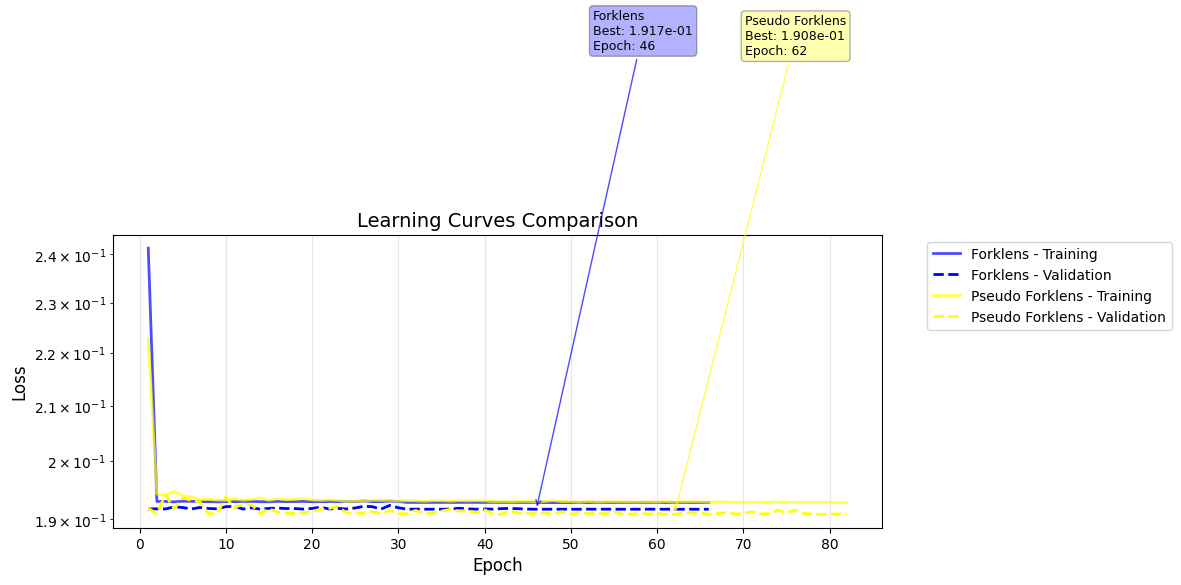

---


In [4]:
with experiment_section("Learning Curves Comparison"):
    base_data_path = os.getenv('SHEARNET_DATA_PATH', os.path.abspath('.'))

    # Create the plot
    plt.figure(figsize=(12, 8))

    for config in model_configs:
        # Load loss data for this model
        loss_file = os.path.join(base_data_path, "plots", config.model_dir_prefix, f"{config.model_dir_prefix}_loss.npz")
        
        if os.path.exists(loss_file):
            loss = np.load(loss_file)
            train_loss = loss['train_loss']
            val_loss = loss['val_loss']
            
            epochs = np.arange(1, len(train_loss) + 1)
            
            # Plot with model-specific colors
            plt.plot(epochs, train_loss, color=config.color, linestyle='-', 
                    label=f'{config.name} - Training', linewidth=2, alpha=0.7)
            plt.plot(epochs, val_loss, color=config.color, linestyle='--', 
                    label=f'{config.name} - Validation', linewidth=2)
            
            # Add annotations for best validation loss
            best_val_epoch = np.argmin(val_loss) + 1
            best_val_loss = np.min(val_loss)
            plt.annotate(f'{config.name}\nBest: {best_val_loss:.3e}\nEpoch: {best_val_epoch}',
                        xy=(best_val_epoch, best_val_loss), 
                        xytext=(best_val_epoch + len(epochs)*0.1, best_val_loss * 1.5),
                        arrowprops=dict(arrowstyle='->', color=config.color, alpha=0.7),
                        fontsize=9,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor=config.color, alpha=0.3))
            
            # Log statistics
            log_print(f"{config.name}:")
            log_print(f"  Final training loss: {train_loss[-1]:.6f}")
            log_print(f"  Final validation loss: {val_loss[-1]:.6f}") 
            log_print(f"  Best validation loss: {best_val_loss:.6f} at epoch {best_val_epoch}")
            log_print(f"  Total epochs: {len(train_loss)}")
        else:
            log_print(f"Warning: Loss file not found for {config.name}: {loss_file}")

    plt.yscale("log")
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Learning Curves Comparison', fontsize=14)
    plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save plot and show
    save_plot("learning_curves_comparison.png")
    plt.show()

In [5]:
with experiment_section("Model Loading and Evaluation"):
    base_checkpoint_path = os.path.join(base_data_path, "model_checkpoint")

    # Dictionary to store all results
    all_results = {}

    # Evaluate each ShearNet model
    for model_config in model_configs:
        log_print(f"\nEvaluating {model_config.name}...")
        results = load_model_and_evaluate(model_config, rng_key, test_galaxy_images, test_psf_images, test_labels, base_checkpoint_path, base_data_path)
        all_results[model_config.name] = {
            'preds': results["all_preds"],
            'config': model_config,
            'type': 'shearnet'
        }

    # Evaluate NGMix if requested
    if include_ngmix:
        log_print(f"\nEvaluating NGMix...")
        ngmix_results = eval_ngmix(test_obs, test_labels, seed=1234)
        all_results['NGMix'] = {
            'preds': ngmix_results["preds"],
            'config': None,
            'type': 'ngmix'
        }

    log_print(f"\nAll evaluations complete! Models: {list(all_results.keys())}")

Model Loading and Evaluation
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md

Evaluating Forklens...
Loading architecture from: /home/adfield/ShearNet/plots/forklens/architecture.py
Found model class: ForkLike
Found 2 matching directories for Forklens: ['forklens_old_optimizer+lr_scheduler82', 'forklens66']
Loading Forklens from: /home/adfield/ShearNet/model_checkpoint/forklens_old_optimizer+lr_scheduler82


2025-07-15 19:01:24.404910: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.



=== Combined Metrics (ShearNet) ===
Mean Squared Error (MSE) from ShearNet: 1.953269e-01
Average Bias from ShearNet: 1.651369e-02
Time taken: 5.88 seconds

=== Per-Label Metrics ===
             g1: MSE = 3.318968e-02, Bias = +1.501400e-02
             g2: MSE = 3.516516e-02, Bias = +6.305563e-03
  g1g2_combined: MSE = 3.417743e-02, Bias = +1.065979e-02
          sigma: MSE = 3.991844e-02, Bias = -1.041190e-02
           flux: MSE = 6.730344e-01, Bias = +5.514707e-02


Evaluating Pseudo Forklens...
Loading architecture from: /home/adfield/ShearNet/plots/forklens_old_optimizer+lr_scheduler/architecture.py
Found model class: ForkLike
Found 1 matching directories for Pseudo Forklens: ['forklens_old_optimizer+lr_scheduler82']
Loading Pseudo Forklens from: /home/adfield/ShearNet/model_checkpoint/forklens_old_optimizer+lr_scheduler82

=== Combined Metrics (ShearNet) ===
Mean Squared Error (MSE) from ShearNet: 1.953269e-01
Average Bias from ShearNet: 1.651369e-02
Time taken: 1.90 seconds

==

In [6]:
with experiment_section("Model Evaluation Summary"):
    # True values
    g1_true = test_labels[:, 0]
    g2_true = test_labels[:, 1]  
    sigma_true = test_labels[:, 2]
    flux_true = test_labels[:, 3]

    # Print summary statistics for all models
    log_print("="*60)
    log_print("EVALUATION SUMMARY", level="SUBHEADER")
    log_print("="*60)

    for model_name, result in all_results.items():
        preds = result['preds']
        log_print(f"\n{model_name}:")
        for i, param in enumerate(["g1", "g2", "sigma", "flux"]):
            true_vals = test_labels[:, i]
            pred_vals = preds[:, i]
            rmse = np.sqrt(np.mean((pred_vals - true_vals)**2))
            bias = np.mean(pred_vals - true_vals)
            log_print(f"  {param:5s}: RMSE = {rmse:.6f}, Bias = {bias:.6f}")

    log_print(f"\nReady for plotting with {len(all_results)} models")

Model Evaluation Summary
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md
EVALUATION SUMMARY

Forklens:
  g1   : RMSE = 0.257642, Bias = 0.015014
  g2   : RMSE = 0.265199, Bias = 0.006306
  sigma: RMSE = 0.282554, Bias = -0.010412
  flux : RMSE = 1.160202, Bias = 0.055147

Pseudo Forklens:
  g1   : RMSE = 0.257642, Bias = 0.015014
  g2   : RMSE = 0.265199, Bias = 0.006306
  sigma: RMSE = 0.282554, Bias = -0.010412
  flux : RMSE = 1.160202, Bias = 0.055147

Ready for plotting with 2 models
---


Prediction Comparison Plots
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md
DEBUG: Attempting to save plot to: /home/adfield/ShearNet/notebooks/out/prediction_comparison_20250715_190138.png
SUCCESS: Plot saved to /home/adfield/ShearNet/notebooks/out/prediction_comparison_20250715_190138.png (size: 523847 bytes)
![prediction_comparison_20250715_190138.png](prediction_comparison_20250715_190138.png)


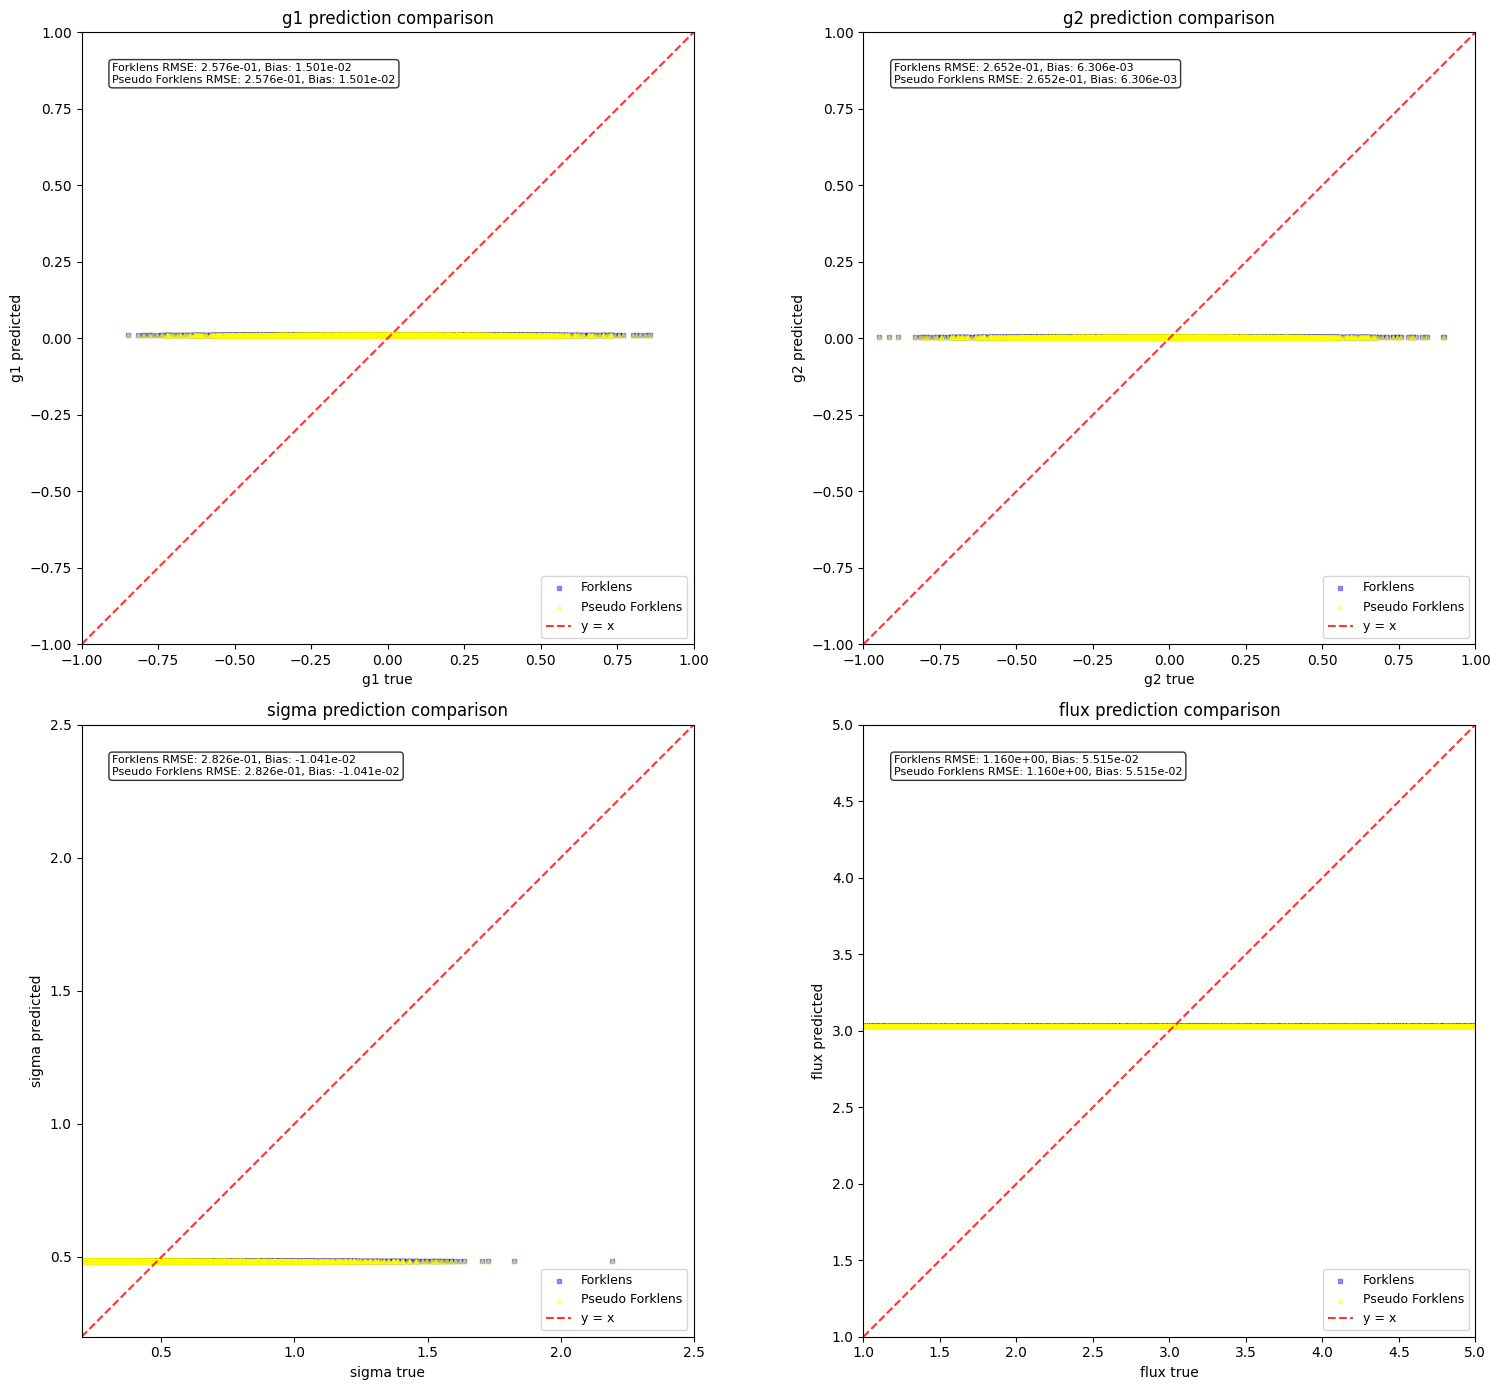

---


In [7]:
with experiment_section("Prediction Comparison Plots"):
    # Set up plot
    fig, axs = plt.subplots(2, 2, figsize=(16, 14))

    quantities = [
        ("g1", g1_true, -1., 1.),
        ("g2", g2_true, -1., 1.),
        ("sigma", sigma_true, 0.2, 2.5),
        ("flux", flux_true, 1, 5.)
    ]

    for ax, (name, true_vals, vmin, vmax) in zip(axs.flat, quantities):
        param_idx = ["g1", "g2", "sigma", "flux"].index(name)
        
        # Plot each model's predictions
        for model_name, result in all_results.items():
            preds = result['preds'][:, param_idx]
            
            if result['type'] == 'ngmix':
                color = 'green'
                marker = '^'
                label = model_name
            else:
                color = result['config'].color
                marker = result['config'].marker
                label = model_name
            
            ax.scatter(true_vals, preds, alpha=0.4, label=label, s=10, 
                      color=color, marker=marker)
        
        # Reference line
        ax.plot([vmin, vmax], [vmin, vmax], 'r--', label='y = x', alpha=0.8)
        
        # Axes formatting
        ax.set_xlim(vmin, vmax)
        ax.set_ylim(vmin, vmax)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel(f"{name} true")
        ax.set_ylabel(f"{name} predicted")
        ax.set_title(f"{name} prediction comparison")

        # Calculate and display metrics
        metrics_text = ""
        for model_name, result in all_results.items():
            preds = result['preds'][:, param_idx]
            rmse = np.sqrt(np.mean((preds - true_vals)**2))
            bias = np.mean(preds - true_vals)
            metrics_text += f"{model_name} RMSE: {rmse:.3e}, Bias: {bias:.3e}\n"

        ax.text(0.05, 0.95, metrics_text.strip(),
                transform=ax.transAxes, fontsize=8,
                verticalalignment='top',
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

        ax.legend(fontsize=9)

    plt.tight_layout()
    
    # Save plot and show
    save_plot("prediction_comparison.png")
    plt.show()

Residuals Comparison Plots
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md
DEBUG: Attempting to save plot to: /home/adfield/ShearNet/notebooks/out/residuals_comparison_20250715_190145.png
SUCCESS: Plot saved to /home/adfield/ShearNet/notebooks/out/residuals_comparison_20250715_190145.png (size: 314404 bytes)
![residuals_comparison_20250715_190145.png](residuals_comparison_20250715_190145.png)


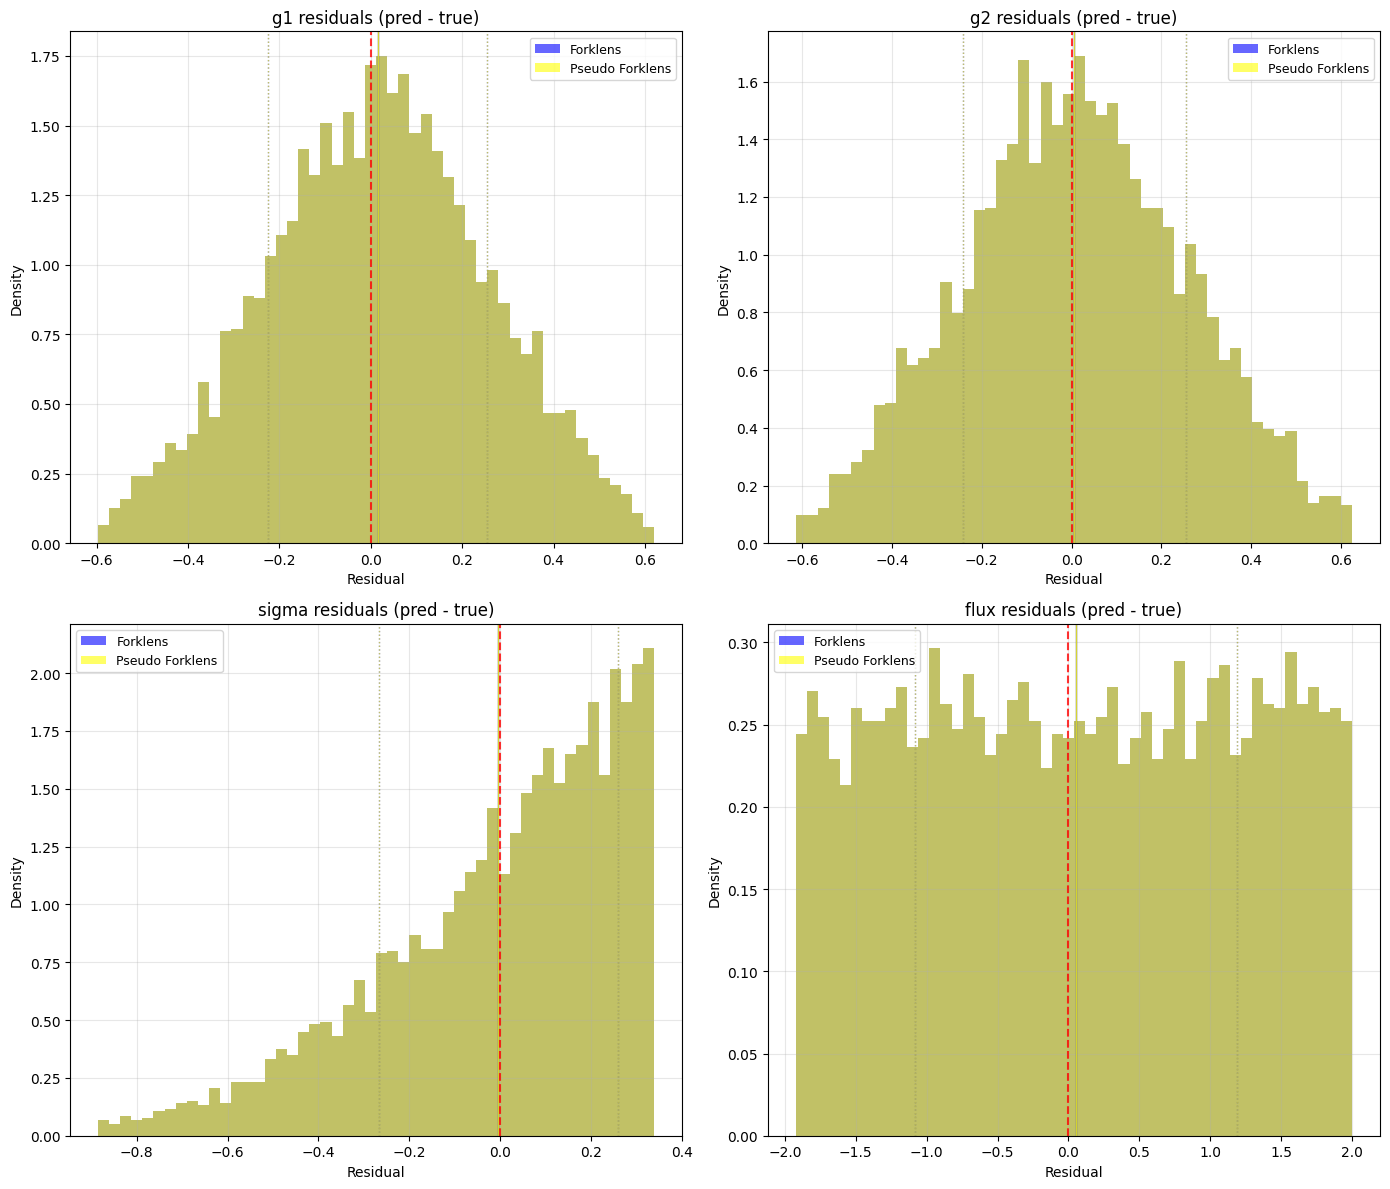

---
Multi-model benchmark complete!
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md


In [8]:
with experiment_section("Residuals Comparison Plots"):
    # Compute residuals for all models
    residuals_data = {}
    for model_name, result in all_results.items():
        preds = result['preds']
        residuals_data[model_name] = {
            "g1": preds[:, 0] - test_labels[:, 0],
            "g2": preds[:, 1] - test_labels[:, 1], 
            "sigma": preds[:, 2] - test_labels[:, 2],
            "flux": preds[:, 3] - test_labels[:, 3],
            "result": result
        }

    fig, axs = plt.subplots(2, 2, figsize=(14, 12))
    bins = 50

    for ax, param in zip(axs.flat, ["g1", "g2", "sigma", "flux"]):
        # Collect all residuals for this parameter to determine clipping
        all_residuals = []
        for model_name, model_residuals in residuals_data.items():
            all_residuals.extend(model_residuals[param])
        
        # Clip extremes to focus on the bulk distribution
        clip_min = np.percentile(all_residuals, 1)
        clip_max = np.percentile(all_residuals, 99)

        # Plot histograms for each model
        for model_name, model_residuals in residuals_data.items():
            residuals = model_residuals[param]
            result = model_residuals["result"]
            
            # Clip residuals
            residuals_clipped = residuals[(residuals >= clip_min) & (residuals <= clip_max)]
            
            if result['type'] == 'ngmix':
                color = 'green'
                label = model_name
            else:
                color = result['config'].color
                label = model_name
            
            ax.hist(residuals_clipped, bins=bins, alpha=0.6, label=label, 
                   color=color, density=True)
            
            # Add mean ± std lines
            mean = np.mean(residuals_clipped)
            std = np.std(residuals_clipped)
            ax.axvline(mean, color=color, linestyle='-', linewidth=1, alpha=0.8)
            ax.axvline(mean + std, color=color, linestyle=':', linewidth=1, alpha=0.6)
            ax.axvline(mean - std, color=color, linestyle=':', linewidth=1, alpha=0.6)
        
        ax.axvline(0, color='red', linestyle='--', alpha=0.8)
        
        # Labels
        ax.set_title(f"{param} residuals (pred - true)")
        ax.set_xlabel("Residual")
        ax.set_ylabel("Density")
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    
    # Save plot and show
    save_plot("residuals_comparison.png")
    plt.show()

log_print("Multi-model benchmark complete!", level="HEADER")